In [1]:
import torch
import os

from torchvision.transforms import GaussianBlur

from util.dataset import load_celeb_a, load_mnist
from util.plot_util import plot_images, save_images
from util.model_util import load_checkpoint, load_model
from generate import rec_generate_images

In [2]:
def add_noise(x: torch.Tensor, mean=0.0, std=0.15):
    return (x + torch.randn_like(x) * std + mean)

def make_grayscale(x: torch.Tensor):
    """x: shape [batch_size, channels, width, height]"""
    if x.shape[1] == 1:
        return x
    return x.mean(dim=1, keepdim=True).repeat(1,3,1,1)

def make_sketch(x: torch.Tensor, kernel_size=21, eps=1e-10):
    gaussian = GaussianBlur(kernel_size=kernel_size, sigma=0.3*((kernel_size-1)*0.5-1)+0.8)
    gs = make_grayscale(x + 1)
    return gs / (gaussian(gs) + eps) - 1

def mask_image(x: torch.Tensor, mean=0.0, std=1.0, patch_size=(5, 10)):
    N, C, H, W = x.shape
    
    # Ensure the patch size is valid
    assert patch_size[0] <= H and patch_size[1] <= W, "Patch size must fit within the image dimensions."
    
    # Clone the input to avoid modifying the original images
    images = x.clone()
    
    # Generate random top-left corners for the patch for each image in the batch
    tops = torch.randint(0, H - patch_size[0] + 1, (N,))
    lefts = torch.randint(0, W - patch_size[1] + 1, (N,))
    
    for i in range(N):
        # Generate Gaussian noise for the patch
        noise = torch.normal(mean=mean, std=std, size=(C, patch_size[0], patch_size[1]))
        
        # Replace the selected patch with noise
        images[i, :, tops[i]:tops[i] + patch_size[0], lefts[i]:lefts[i] + patch_size[1]] = noise
    
    return images

In [3]:

# Setup
run_id = "checkpoints_old/CELEBA_FINAL_FOURIER_epoch_1000.pt"
eval_mode = False
n_images = 5
n_recursions = 3
normalized = True # True if images are in range [-1, 1]
save_reconstructions = True
image_dir = "ood_images/"
y_input_is_None = False # Used to make unconditional images when using conditional model
force_conditional = False # Use this when model name is wrong for a conditional model

# Make image dir
if save_reconstructions:
    os.makedirs(image_dir, exist_ok=True)

# Loading model and data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
checkpoint = load_checkpoint(run_id)
model = load_model(checkpoint, device, force_conditional)

is_conditional = "conditional" in checkpoint["config"]["model"]["architecture"].lower() or force_conditional
grayscale = "mnist" in checkpoint['config']['dataset']['name'].lower()
use_fourier_sampling = checkpoint['config']['training']['use_fourier_sampling']
if grayscale:
    _, data = load_mnist(batch_size=checkpoint['config']['training']['batch_size'], single_channel=True)
else:
    data = load_celeb_a(batch_size=checkpoint['config']['training']['batch_size'], split='test')

model.to(device)
if eval_mode:
    model.eval()
else:
    model.train()

Files already downloaded and verified


100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


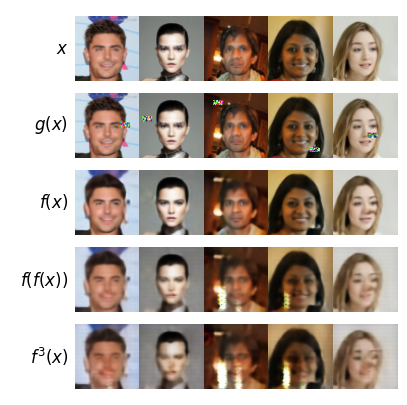

In [4]:
# Masked
original, reconstructed = rec_generate_images(
    model=model,
    device=device,
    data=data,
    n_images=n_images,
    n_recursions=n_recursions,
    reconstruct=True,
    use_fourier_sampling=use_fourier_sampling,
    transforms=[
        mask_image,
    ],
    loading_bar=True,
    with_label=is_conditional,
    y_input_is_None=y_input_is_None,
)
plot_images(
    original,
    reconstructed,
    grayscale=grayscale,
    normalized=normalized,
    transformed=True,
)

if save_reconstructions:
    save_images(
        original,
        reconstructed,
        grayscale=grayscale,
        normalized=normalized,
        transformed=True,
        output_path=os.path.join(image_dir, f"{run_id.split('/')[-1].removesuffix('.pt')}_masked.png"),
    )

100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


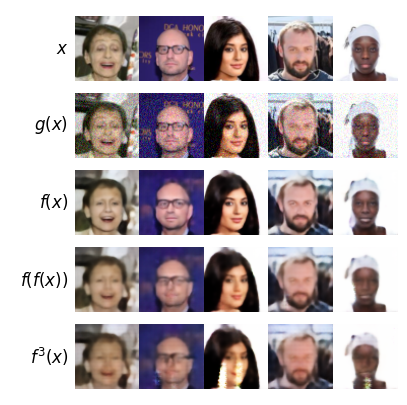

In [5]:
# Noise
original, reconstructed = rec_generate_images(
    model=model,
    device=device,
    data=data,
    n_images=n_images,
    n_recursions=n_recursions,
    reconstruct=True,
    use_fourier_sampling=use_fourier_sampling,
    transforms=[
        add_noise,
    ],
    loading_bar=True,
    with_label=is_conditional,
    y_input_is_None=y_input_is_None,
)
plot_images(
    original,
    reconstructed,
    grayscale=grayscale,
    normalized=normalized,
    transformed=True,
)

if save_reconstructions:
    save_images(
        original,
        reconstructed,
        grayscale=grayscale,
        normalized=normalized,
        transformed=True,
        output_path=os.path.join(image_dir, f"{run_id.split('/')[-1].removesuffix('.pt')}_added_noise.png"),
    )

100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


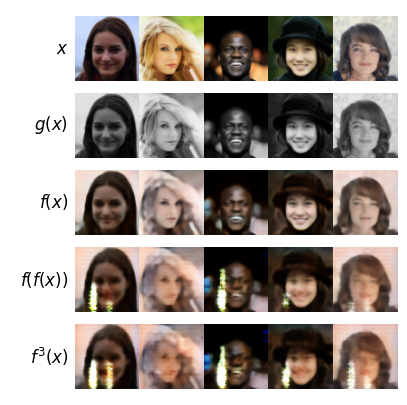

In [6]:
# Grayscale
original, reconstructed = rec_generate_images(
    model=model,
    device=device,
    data=data,
    n_images=n_images,
    n_recursions=n_recursions,
    reconstruct=True,
    use_fourier_sampling=use_fourier_sampling,
    transforms=[
        make_grayscale,
    ],
    loading_bar=True,
    with_label=is_conditional,
    y_input_is_None=y_input_is_None,
)
plot_images(
    original,
    reconstructed,
    grayscale=grayscale,
    normalized=normalized,
    transformed=True,
)

if save_reconstructions:
    save_images(
        original,
        reconstructed,
        grayscale=grayscale,
        normalized=normalized,
        transformed=True,
        output_path=os.path.join(image_dir, f"{run_id.split('/')[-1].removesuffix('.pt')}_grayscale.png"),
    )

100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


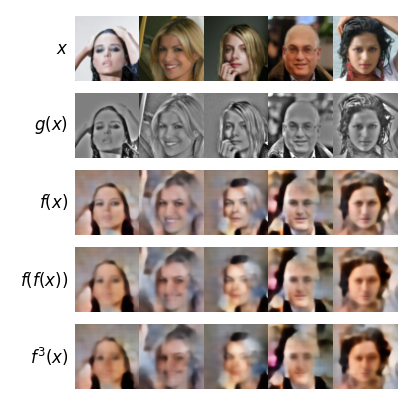

In [7]:
# Sketch
original, reconstructed = rec_generate_images(
    model=model,
    device=device,
    data=data,
    n_images=n_images,
    n_recursions=n_recursions,
    reconstruct=True,
    use_fourier_sampling=use_fourier_sampling,
    transforms=[
        make_sketch,
    ],
    loading_bar=True,
    with_label=is_conditional,
    y_input_is_None=y_input_is_None,
)
plot_images(
    original,
    reconstructed,
    grayscale=grayscale,
    normalized=normalized,
    transformed=True,
)

if save_reconstructions:
    save_images(
        original,
        reconstructed,
        grayscale=grayscale,
        normalized=normalized,
        transformed=True,
        output_path=os.path.join(image_dir, f"{run_id.split('/')[-1].removesuffix('.pt')}_sketch.png"),
    )